# Project Description

The telecom operator Interconnect would like to be able to forecast their churn of clients. If it's discovered that a user is planning to leave, they will be offered promotional codes and special plan options. Interconnect's marketing team has collected some of their clientele's personal data, including information about their plans and contracts.

### Interconnect's services

Interconnect mainly provides two types of services:<br>

1. Internet. The network can be set up via a telephone line (DSL, *digital subscriber line*) or through a fiber optic cable.<br>
    1. Landline communication. The telephone can be connected to several lines simultaneously.<br>

Some other services the company provides include:<br>

- Internet security: antivirus software (*DeviceProtection*) and a malicious website blocker (*OnlineSecurity*)<br>
- A dedicated technical support line (*TechSupport*)<br>
- Cloud file storage and data backup (*OnlineBackup*)<br>
- TV streaming (*StreamingTV*) and a movie directory (*StreamingMovies*)<br>

The clients can choose either a monthly payment or sign a 1- or 2-year contract. They can use various payment methods and receive an electronic invoice after a transaction.<br>

### Data Description

The data consists of files obtained from different sources:<br>

- `contract.csv` — contract information<br>
- `personal.csv` — the client's personal data<br>
- `internet.csv` — information about Internet services<br>
- `phone.csv` — information about telephone services<br>

In each file, the column `customerID` contains a unique code assigned to each client.<br>

The contract information is valid as of February 1, 2020.<br>

### Target

Primary metric: AUC-ROC. This metric should be above 0.88.<br>

Additional metric: Accuracy.

# Initialization

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_profiling import ProfileReport
from functools import reduce
from sklearn.model_selection import train_test_split, KFold, RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler

from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
from sklearn.model_selection import cross_val_score, GridSearchCV

from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, \
    GradientBoostingClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.linear_model import SGDClassifier
from imblearn.pipeline import Pipeline
from sklearn.svm import OneClassSVM
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
import os

In [2]:
# Load data
contract = pd.read_csv('final_provider/contract.csv')
internet = pd.read_csv('final_provider/internet.csv')
personal = pd.read_csv('final_provider/personal.csv')
phone = pd.read_csv('final_provider/phone.csv')

In [3]:
# give names to data frames
df_names = ['contract', 'internet', 'personal', 'phone']
data_frames = [contract, personal, phone, internet]
for i in range(len(df_names)):
    data_frames[i].name = df_names[i]

In [4]:
display(contract.head(5))
display(personal.head(5))
display(internet.head(5))
display(phone.head(5))

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [5]:
def data_dublicates(data):
    '''
    Function takes a dataset as an agrument
    and prints its name, number of dublicated rows and sum 
    of row with missing values'''
    
    print('TABLE: ', str.upper(df.name))
    print('Number of dublicated rows: ', data.duplicated().sum())
    print('Number of missing values:  ', data.isna().sum().sum())
    print('')

In [6]:
for df in data_frames:
    data_dublicates(df)

TABLE:  CONTRACT
Number of dublicated rows:  0
Number of missing values:   0

TABLE:  INTERNET
Number of dublicated rows:  0
Number of missing values:   0

TABLE:  PERSONAL
Number of dublicated rows:  0
Number of missing values:   0

TABLE:  PHONE
Number of dublicated rows:  0
Number of missing values:   0



# Part I: EDA and Data Preparation

#### Target Column and Duration

In [7]:
# new column: customer has left = 1, customer is current = 0
contract['left'] = contract['EndDate'].apply(lambda x: 0 if x=='No' else 1)

In [8]:
# percentage of customers who is still with the company - 0, and who has left -1
round(100*contract.left.value_counts()/contract.shape[0], 2)

0    73.46
1    26.54
Name: left, dtype: float64

In [9]:
# from object type to numeric
contract.TotalCharges = pd.to_numeric(contract.TotalCharges, errors='coerce')
# from object type to datetime
contract.BeginDate = pd.to_datetime(contract.BeginDate)
contract.EndDate = pd.to_datetime(contract.EndDate, errors='coerce')

In [10]:
print("Erliest begin date", contract['BeginDate'].min())
print("Latest end date in the dataset", contract[contract['EndDate']!="NaT"]['EndDate'].max())

Erliest begin date 2013-10-01 00:00:00
Latest end date in the dataset 2020-01-01 00:00:00


In [11]:
# replacing NaT with latest time stamp
contract['EndDate'] = contract['EndDate'].fillna(pd.to_datetime('2020-01-01 00:00:00'))
# creating a new column for duration of service in days
contract['duration'] = (contract.EndDate - contract.BeginDate).dt.days

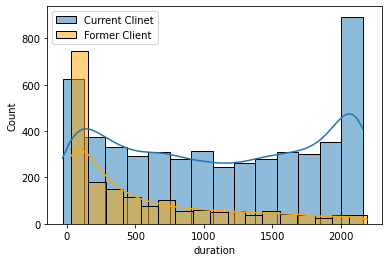

In [12]:
# plotting a distribution of service duration vs client status
sns.histplot(data=contract.loc[contract['left'] == 0]['duration'], 
             kde=True, label='Current Clinet'),
sns.histplot(data=contract.loc[contract['left'] == 1]['duration'],
             kde=True, label='Former Client', color="orange", alpha=.5)
plt.legend();

Clients who has left tend to terminate their service in the beginning.

In [13]:
# dropping two columns
contract.drop(['EndDate', 'BeginDate'], inplace=True, axis=1)

#### Monthly Charges

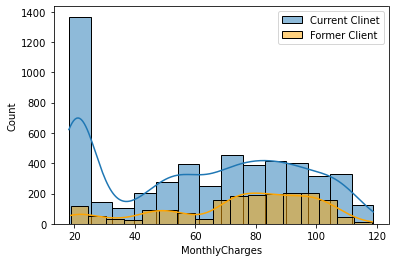

In [14]:
sns.histplot(data=contract.loc[contract['left'] == 0]['MonthlyCharges'], 
             kde=True, label='Current Clinet'),
sns.histplot(data=contract.loc[contract['left'] == 1]['MonthlyCharges'],
             kde=True, label='Former Client', color="orange")
plt.legend();

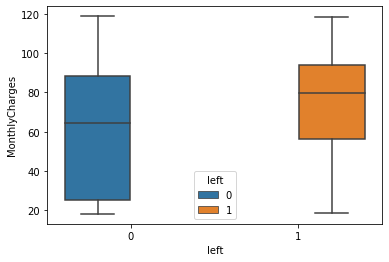

In [15]:
sns.boxplot(x='left', y='MonthlyCharges', data=contract, hue='left')

plt.show()

In [16]:
# creating a df with stats
Monthly_Charges = contract.groupby('left').agg(['min', 'max','mean', 'median', 'var']).MonthlyCharges
# adding percentiles
Monthly_Charges['25_percentile'] = [np.percentile(contract.query('left == 0').MonthlyCharges, 25), 
                                   np.percentile( contract.query('left == 1').MonthlyCharges, 25)]
Monthly_Charges['75_percentile'] = [np.percentile(contract.query('left == 0').MonthlyCharges, 75), 
                                   np.percentile(contract.query('left == 1').MonthlyCharges, 75)]
Monthly_Charges

,min,max,mean,median,var,25_percentile,75_percentile
left,,,,,,,
0,18.25,118.75,61.265124,64.425,966.752767,25.10,88.4
1,18.85,118.35,74.441332,79.650,608.414183,56.15,94.2


#### Share of telephone and Internet users

In [17]:
print('Internet Unique: ', internet['customerID'].nunique())
print('Phone Unique: ', phone['customerID'].nunique())

Internet Unique:  5517
Phone Unique:  6361


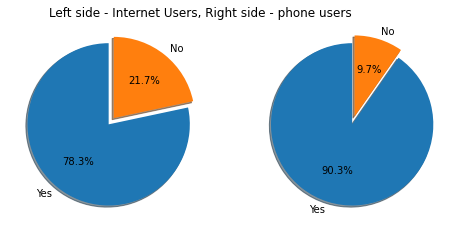

In [18]:
# Plotting percentage of internet/phone use. All records.
# ax1,ax2 refer to your two pies
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
# Share of internet users
labels = 'Yes', 'No'
sizes = [internet['customerID'].nunique()/contract.shape[0],
         1 - internet['customerID'].nunique()/contract.shape[0]]
explode = (0, 0.1)  # only "explode" the 2nd slice (i.e. 'No')
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)


# share of phone users
sizes = [phone['customerID'].nunique()/contract.shape[0],
         1 - phone['customerID'].nunique()/contract.shape[0]]
explode = (0, 0.1)  # only "explode" the 2nd slice (i.e. 'No')
ax2.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
plt.title("Left side - Internet Users, Right side - phone users",
          fontdict={'horizontalalignment': 'right'})

plt.show()

## Merging all tables

In [19]:
big_df = reduce(lambda  left, right: pd.merge(left,right,on=['customerID'], how='outer'), data_frames)

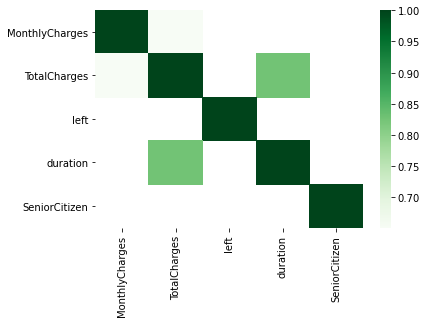

In [20]:
# Create correlation matrix
corr = big_df.corr()
# display pairs with corr coef greater than 0.5
kot = corr[corr>=.5]
plt.figure(figsize=(6,4))
sns.heatmap(kot, cmap="Greens");

In [21]:
categorical = ['Type', 'PaperlessBilling', 'PaymentMethod',
               'gender', 'Partner', 'Dependents', 'MultipleLines', 
               'InternetService', 'OnlineSecurity', 'OnlineBackup', 
              'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']

In [22]:
big_df = pd.get_dummies(big_df, columns = categorical, drop_first=True)
print(big_df.shape)

(7043, 23)


In [23]:
big_df.isna().sum()

customerID                                0
MonthlyCharges                            0
TotalCharges                             11
left                                      0
duration                                  0
SeniorCitizen                             0
Type_One year                             0
Type_Two year                             0
PaperlessBilling_Yes                      0
PaymentMethod_Credit card (automatic)     0
PaymentMethod_Electronic check            0
PaymentMethod_Mailed check                0
gender_Male                               0
Partner_Yes                               0
Dependents_Yes                            0
MultipleLines_Yes                         0
InternetService_Fiber optic               0
OnlineSecurity_Yes                        0
OnlineBackup_Yes                          0
DeviceProtection_Yes                      0
TechSupport_Yes                           0
StreamingTV_Yes                           0
StreamingMovies_Yes             

Zeros in "total charges" table have become missing values. Let's drop them.

In [24]:
big_df.dropna(inplace=True)
print(big_df.shape)

(7032, 23)


In [25]:
# removing useless feature - customer ID
big_df.drop(['customerID'], axis=1, inplace=True)

In [26]:
X = big_df.drop(['left'], axis=1)
y = big_df['left']

In [27]:
# Scaling numerical variables
numeric_cols = ["TotalCharges", "MonthlyCharges", "duration"]
scaler = StandardScaler()
scaler.fit(X[numeric_cols])
X[numeric_cols] = scaler.transform(X[numeric_cols])

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=12345)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(5625, 21) (5625,) (1407, 21) (1407,)


<b>EDA Conclusion:</b><br> The datasets contain information about customers who has left the telecom company (26%) and customers who is still with the company (74%). We can see that customers who left the company on average paid more in monthly charges. There are more customers who just use phone service vs customers who use Internet.

# Part II: Model Selection

In [29]:
def display_accuracy(model):
    '''function to display ROC AUC metric and accuracy of a model
    for train and test sets'''
    
    # fitting model
    model.fit(X_train, y_train)
    
    # predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
        
    # accuracy metrics
    f1_train = f1_score(y_train, y_train_pred)
    f1_test = f1_score(y_test, y_test_pred)
    
    acc_train = model.score(X_train, y_train)
    acc_test = model.score(X_test, y_test)
    
    roc_auc_train = f1_score(y_train, y_train_pred)
    roc_auc_test = f1_score(y_test, y_test_pred)
        
    # making data frame with results
    df = pd.DataFrame(data={'ROC AUC': [roc_auc_train, roc_auc_test],
                            'F1 Score': [f1_train, f1_test],
                            'Accuracy': [acc_train, acc_test]}, index=['train set', 'test_set'])
    display(df)
    return

## Dummy Model

In [30]:
model = DummyClassifier()
display_accuracy(DummyClassifier())

,ROC AUC,F1 Score,Accuracy
train set,0.0,0.0,0.735822
test_set,0.0,0.0,0.727790


## Quick Model Selection with Cross-Validation

Let's check how several model will perform with default hyper-parameters. We will be using 10-fold cross-validation to estimate ROC AUC on train and test sets.

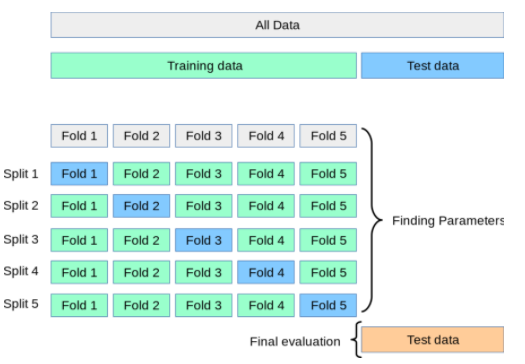

In [31]:
from IPython.display import Image
Image("k-fold cv.png")

 <a href=https://scikit-learn.org/stable/modules/cross_validation.html>Picture source</a>

In [32]:
models = []
models.append(('LR  ', LogisticRegression()))
models.append(('LDA ', LinearDiscriminantAnalysis()))
models.append(('KNN ', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB  ', GaussianNB()))
models.append(('LSVC', LinearSVC()))
models.append(('SVC ', SVC()))
models.append(('BG  ', BaggingClassifier()))
models.append(('RF  ', RandomForestClassifier()))
models.append(('ET  ', ExtraTreesClassifier()))
models.append(('AB  ', AdaBoostClassifier()))
models.append(('GB  ', GradientBoostingClassifier()))

The models are evaluated using 5-fold cross-validation and the oversampling is performed on the training dataset within each fold separately, ensuring that there is no data leakage as might occur if the oversampling was performed prior to the cross-validation.

In [33]:
cv_results_roc = []
cv_results_f1 = []
cv_results_accuracy = []
names = []
msg_row = []

for name, model in models:
    kfold = KFold()
    cv_results_roc = cross_val_score(model, X_train, y_train, cv=kfold, scoring='roc_auc')
    cv_results_f1 = cross_val_score(model, X_train, y_train, cv=kfold, scoring='f1')
    cv_results_accuracy = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')
    names.append(name)
    msg = "%s: ROC AUC = %.3f (std = %.3f) F1 Score = %.3f Accuracy = %.3f"  % \
            (name, cv_results_roc.mean(), 
             cv_results_roc.std(),
             cv_results_f1.mean(),
             cv_results_accuracy.mean())
    msg_row.append(msg)
    print(msg)

LR  : ROC AUC = 0.833 (std = 0.009) F1 Score = 0.558 Accuracy = 0.794
LDA : ROC AUC = 0.830 (std = 0.010) F1 Score = 0.572 Accuracy = 0.792
KNN : ROC AUC = 0.790 (std = 0.008) F1 Score = 0.550 Accuracy = 0.771
CART: ROC AUC = 0.742 (std = 0.007) F1 Score = 0.624 Accuracy = 0.795
NB  : ROC AUC = 0.824 (std = 0.011) F1 Score = 0.613 Accuracy = 0.749
LSVC: ROC AUC = 0.831 (std = 0.010) F1 Score = 0.556 Accuracy = 0.793
SVC : ROC AUC = 0.810 (std = 0.009) F1 Score = 0.541 Accuracy = 0.796
BG  : ROC AUC = 0.869 (std = 0.003) F1 Score = 0.642 Accuracy = 0.837
RF  : ROC AUC = 0.861 (std = 0.008) F1 Score = 0.618 Accuracy = 0.822
ET  : ROC AUC = 0.831 (std = 0.007) F1 Score = 0.562 Accuracy = 0.795
AB  : ROC AUC = 0.881 (std = 0.006) F1 Score = 0.658 Accuracy = 0.836
GB  : ROC AUC = 0.888 (std = 0.005) F1 Score = 0.657 Accuracy = 0.842


In [34]:
best_models = []
best_models.append(('AB  ', AdaBoostClassifier()))
best_models.append(('GB  ', GradientBoostingClassifier()))

In [35]:
cv_results_roc = []
cv_results_f1 = []
cv_results_accuracy = []
names = []
msg_row = []

for name, model in best_models:
    # define pipeline
    steps = [('over', RandomOverSampler()), ('model', model)]
    pipeline = Pipeline(steps=steps)
    kfold = KFold()
    # evaluate pipeline
    cv_results_roc = cross_val_score(model, X_train, y_train, cv=kfold, scoring='roc_auc')
    cv_results_f1 = cross_val_score(model, X_train, y_train, cv=kfold, scoring='f1')
    cv_results_accuracy = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')
    names.append(name)
    msg = "%s: ROC AUC = %.3f (std = %.3f) F1 Score = %.3f Accuracy = %.3f"  % \
    (name, cv_results_roc.mean(), 
     cv_results_roc.std(),
     cv_results_f1.mean(),
     cv_results_accuracy.mean())
    msg_row.append(msg)
    print(msg)

AB  : ROC AUC = 0.881 (std = 0.006) F1 Score = 0.658 Accuracy = 0.836
GB  : ROC AUC = 0.888 (std = 0.005) F1 Score = 0.657 Accuracy = 0.842


Right of the bat, we can see that there are two models that perform with the value of ROC AUC metric >=0.88. They are AdaBoost Classifier and Gradient Boosting Classifier. Let's see if we can squeeze a bit higher target metric from these models by tuning their hyper-parameters. To tune hyper-parameters we will split the original data set into training and test set. We will use grid search to select best hyper-parameters for each model. Ones best hyper-parameters are determined, we will use them in the code we have just used above, e.g. over-sampling and cross validating.

In [36]:
def display_accuracy_cv(model, n_folds=5):
    '''The function takes a model and a number of k-folds as
    arguments. The function fits the model and calculates
    accuracy metric on train set with CV and on test set w/o CV.
    The function displays accuracy metrics for train and test sets.'''

    # fitting model
    model.fit(X_train, y_train)

    # accuracy metrics
    f1_train = cross_val_score(model, X_train, y_train, cv=n_folds, scoring='f1').mean()  
    f1_test = f1_score(y_test, model.predict(X_test))
    
    acc_train = cross_val_score(
        model, X_train, y_train, cv=n_folds, scoring='accuracy').mean()
    acc_test = model.score(X_test, y_test)
    
    roc_auc_train = cross_val_score(
        model, X_train, y_train, cv=n_folds, scoring='roc_auc').mean()
    roc_auc_test = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

    df = pd.DataFrame(data={'ROC AUC': [roc_auc_train, roc_auc_test],
                            'F1 Score': [f1_train, f1_test],
                            'Accuracy': [acc_train, acc_test]}, index=['train set', 'test_set'])
    display(df)

## Hyper-Parameters Tuning

### AdaBoost Classifier

In [37]:
params = {
    "n_estimators": [50, 100],
    "algorithm": ['SAMME.R', 'SAMME'],
    "learning_rate": [0.5, 1, 1.5]}
ad_clf = GridSearchCV(AdaBoostClassifier(), params,
                   cv=5).fit(X_train, y_train)

In [38]:
ad_clf.best_params_

{'algorithm': 'SAMME.R', 'learning_rate': 1.5, 'n_estimators': 100}

In [39]:
display_accuracy_cv(AdaBoostClassifier(**ad_clf.best_params_))

,ROC AUC,F1 Score,Accuracy
train set,0.891975,0.681602,0.847822
test_set,0.894782,0.704348,0.855011


### Gradient Boosting Classifier

In [40]:
params = {
    "n_estimators": [100, 200],
    "loss": ['deviance', 'exponential'],
    "criterion": ['friedman_mse', 'mse']}
gb_clf = GridSearchCV(GradientBoostingClassifier(), params,
                   cv=5).fit(X_train, y_train)

In [41]:
gb_clf.best_params_

{'criterion': 'friedman_mse', 'loss': 'deviance', 'n_estimators': 200}

In [42]:
display_accuracy_cv(GradientBoostingClassifier(**gb_clf.best_params_))

,ROC AUC,F1 Score,Accuracy
train set,0.896339,0.675884,0.849778
test_set,0.905905,0.700775,0.862829


We checked how the models performed compared to the constant model. They really predict better than a random choice. The target value for the ROC AUC metric was achieved

# Conclusion

The EDA showed that the customers who have left the company paid on average higher in monthly payments. Majority of the clients in the dataset are phone users, their share is about 90%. 78% of the total population are/were Internet users.<br>
For the further analysis we merged all four provided datasets. We encoded all categorical variables and scaled numerical. Then we tried some machine learning models with default hyper-parameters. After that step we selected two best performers and tuned their parameters to achieve the target accuracy metric - ROC AUC.<br>
After tuning hyper-parameters it was discovered that Gradient Boosting Classifier achieved the highest ROC AUC score.<br>